# Simulated orderbook, visualizations, metrics comparison

Sample: 100%|██████████| 600/600 [00:01, 355.25it/s, step size=9.57e-01, acc. prob=0.896]


Ask VB mean=10.044, time=0.83s
Ask MCMC mean=10.017, time=1.69s


Sample: 100%|██████████| 600/600 [00:01, 412.06it/s, step size=1.43e+00, acc. prob=0.858]


Bid VB mean=9.960, time=0.89s
Bid MCMC mean=9.983, time=1.46s


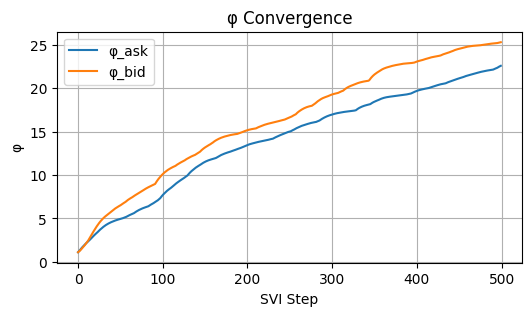

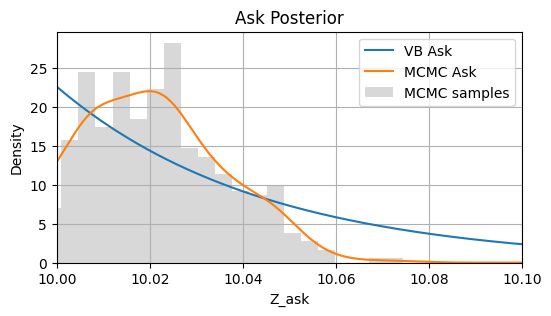

Ask  VB variance = 0.0020, MCMC variance = 0.0003
Ask  KL(q||p)    = 2.0331, KL(p||q)    = 0.1080


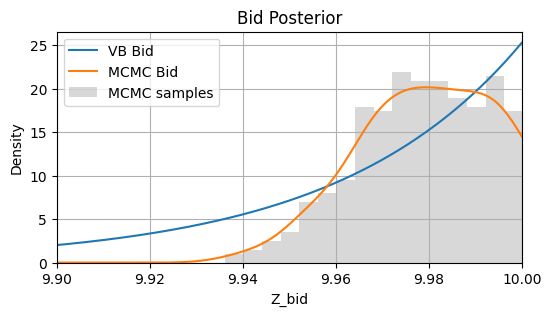

Bid  VB variance = 0.0016, MCMC variance = 0.0003
Bid  KL(q||p)    = 1.9497, KL(p||q)    = 0.0609


In [61]:
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.distributions.transforms import AffineTransform
from pyro.distributions import TransformedDistribution
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
from pyro.optim import Adam

import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -----------------------------------------------------------------------------
# 0) Models & guides parameterized by mid_price
# -----------------------------------------------------------------------------
def model_ask(prices, vols, mid):
    # Z_ask = mid + Y, Y ~ Exp(1)
    base = dist.Exponential(torch.tensor(1.0))
    t = AffineTransform(loc=mid, scale=1.0)
    z = pyro.sample("Z_ask", TransformedDistribution(base, [t]))
    logp = dist.Normal(z, torch.tensor(1.1)).log_prob(prices)
    pyro.factor("obs_ask", (vols * logp).sum())

def guide_ask(prices, vols, mid):
    phi = pyro.param("phi_ask",
                     torch.tensor(1.0),
                     constraint=constraints.positive)
    base_q = dist.Exponential(phi)
    t = AffineTransform(loc=mid, scale=1.0)
    pyro.sample("Z_ask", TransformedDistribution(base_q, [t]))

def model_bid(prices, vols, mid):
    # Z_bid = mid - Y, Y ~ Exp(1)
    base = dist.Exponential(torch.tensor(1.0))
    t = AffineTransform(loc=mid, scale=-1.0)
    z = pyro.sample("Z_bid", TransformedDistribution(base, [t]))
    logp = dist.Normal(z, torch.tensor(1.1)).log_prob(prices)
    pyro.factor("obs_bid", (vols * logp).sum())

def guide_bid(prices, vols, mid):
    phi = pyro.param("phi_bid",
                     torch.tensor(1.0),
                     constraint=constraints.positive)
    base_q = dist.Exponential(phi)
    t = AffineTransform(loc=mid, scale=-1.0)
    pyro.sample("Z_bid", TransformedDistribution(base_q, [t]))

# -----------------------------------------------------------------------------
# 1) VB history runner
# -----------------------------------------------------------------------------
def run_vb_hist(prices, vols, mid, model, guide, phi_name,
                steps=500, lr=1e-3):
    p = torch.tensor(prices, dtype=torch.float32)
    v = torch.tensor(vols,   dtype=torch.float32)
    m = torch.tensor(mid,    dtype=torch.float32)
    pyro.clear_param_store()
    phi_hist = []
    svi = SVI(lambda _: model(p, v, m),
              lambda _: guide(p, v, m),
              Adam({"lr": lr}), Trace_ELBO())
    for _ in range(steps):
        svi.step(None)
        phi_hist.append(pyro.param(phi_name).item())
    φ = pyro.param(phi_name).item()
    mean_z = mid + 1.0/φ if phi_name == "phi_ask" else mid - 1.0/φ
    return phi_hist, φ, mean_z

# -----------------------------------------------------------------------------
# 2) MCMC sampler runner
# -----------------------------------------------------------------------------
def run_mcmc(prices, vols, mid, model, z_name,
             samples=500, warmup=100):
    p = torch.tensor(prices, dtype=torch.float32)
    v = torch.tensor(vols,   dtype=torch.float32)
    m = torch.tensor(mid,    dtype=torch.float32)
    pyro.clear_param_store()
    mcmc = MCMC(NUTS(lambda _: model(p, v, m)),
                num_samples=samples, warmup_steps=warmup)
    mcmc.run(None)
    return mcmc.get_samples()[z_name].cpu().numpy()

# -----------------------------------------------------------------------------
# 3) Synthetic orderbook around mid=10
# -----------------------------------------------------------------------------
mid = 10.0
ask_prices = mid + np.linspace(-0.38, 1, 10)
ask_vols   = np.logspace(3, 2, 10)
bid_prices = mid - np.linspace(-0.38, 1, 10)
bid_vols   = np.logspace(3, 2, 10)

# -----------------------------------------------------------------------------
# 4) VB vs MCMC on the ask side
# -----------------------------------------------------------------------------
t0 = time.time()
ask_phi_hist, ask_phi, z_ask_vb = run_vb_hist(
    ask_prices, ask_vols, mid,
    model_ask, guide_ask, "phi_ask",
    steps=500, lr=1e-1
)
t_vb_ask = time.time() - t0

t0 = time.time()
z_ask_mc_samps = run_mcmc(
    ask_prices, ask_vols, mid,
    model_ask, "Z_ask",
    samples=500, warmup=100
)
t_mc_ask = time.time() - t0
z_ask_mc = z_ask_mc_samps.mean()

print(f"Ask VB mean={z_ask_vb:.3f}, time={t_vb_ask:.2f}s")
print(f"Ask MCMC mean={z_ask_mc:.3f}, time={t_mc_ask:.2f}s")

# -----------------------------------------------------------------------------
# 5) VB vs MCMC on the bid side
# -----------------------------------------------------------------------------
t0 = time.time()
bid_phi_hist, bid_phi, z_bid_vb = run_vb_hist(
    bid_prices, bid_vols, mid,
    model_bid, guide_bid, "phi_bid",
    steps=500, lr=1e-1
)
t_vb_bid = time.time() - t0

t0 = time.time()
z_bid_mc_samps = run_mcmc(
    bid_prices, bid_vols, mid,
    model_bid, "Z_bid",
    samples=500, warmup=100
)
t_mc_bid = time.time() - t0
z_bid_mc = z_bid_mc_samps.mean()

print(f"Bid VB mean={z_bid_vb:.3f}, time={t_vb_bid:.2f}s")
print(f"Bid MCMC mean={z_bid_mc:.3f}, time={t_mc_bid:.2f}s")

# -----------------------------------------------------------------------------
# 6) Plot φ convergence
# -----------------------------------------------------------------------------
plt.figure(figsize=(6,3))
plt.plot(ask_phi_hist, label="φ_ask")
plt.plot(bid_phi_hist, label="φ_bid")
plt.xlabel("SVI Step"); plt.ylabel("φ"); plt.title("φ Convergence")
plt.legend(); plt.grid(); plt.show()

# -----------------------------------------------------------------------------
# 7) Plot ask posterior (Z ≥ mid)
# -----------------------------------------------------------------------------
rng_ask = np.linspace(mid, mid + 3/ask_phi, 500)
vb_pdf_ask = ask_phi * np.exp(-ask_phi * (rng_ask - mid))
mc_pdf_ask = gaussian_kde(z_ask_mc_samps)(rng_ask)

plt.figure(figsize=(6,3))
plt.plot(rng_ask, vb_pdf_ask, label="VB Ask")
plt.plot(rng_ask, mc_pdf_ask, label="MCMC Ask")
plt.xlim(10,10.1)
plt.hist(z_ask_mc_samps, bins=30, density=True, alpha=0.3, color="gray", label="MCMC samples")
plt.xlabel("Z_ask"); plt.ylabel("Density"); plt.title("Ask Posterior"); plt.legend(); plt.grid(); plt.show()

# -----------------------------------------------------------------------------
# 8) Compute ask variance & KL divergences
# -----------------------------------------------------------------------------
var_vb_ask = 1.0 / (ask_phi ** 2)
var_mc_ask = np.var(z_ask_mc_samps, ddof=0)
dz_ask = rng_ask[1] - rng_ask[0]
kl_qp_ask = np.sum(vb_pdf_ask * np.log(vb_pdf_ask / (mc_pdf_ask + 1e-12)) * dz_ask)
kl_pq_ask = np.sum(mc_pdf_ask * np.log(mc_pdf_ask / (vb_pdf_ask + 1e-12)) * dz_ask)

print(f"Ask  VB variance = {var_vb_ask:.4f}, MCMC variance = {var_mc_ask:.4f}")
print(f"Ask  KL(q||p)    = {kl_qp_ask:.4f}, KL(p||q)    = {kl_pq_ask:.4f}")

# -----------------------------------------------------------------------------
# 9) Plot bid posterior (Z ≤ mid)
# -----------------------------------------------------------------------------
rng_bid = np.linspace(mid - 3/bid_phi, mid, 500)
vb_pdf_bid = bid_phi * np.exp(-bid_phi * (mid - rng_bid))
mc_pdf_bid = gaussian_kde(z_bid_mc_samps)(rng_bid)

plt.figure(figsize=(6,3))
plt.plot(rng_bid, vb_pdf_bid, label="VB Bid")
plt.plot(rng_bid, mc_pdf_bid, label="MCMC Bid")
plt.hist(z_bid_mc_samps, bins=30, density=True, alpha=0.3, color="gray", label="MCMC samples")
plt.xlim(9.9,10)

plt.xlabel("Z_bid"); plt.ylabel("Density"); plt.title("Bid Posterior"); plt.legend(); plt.grid(); plt.show()

# -----------------------------------------------------------------------------
# 10) Compute bid variance & KL divergences
# -----------------------------------------------------------------------------
var_vb_bid = 1.0 / (bid_phi ** 2)
var_mc_bid = np.var(z_bid_mc_samps, ddof=0)
dz_bid = rng_bid[1] - rng_bid[0]
kl_qp_bid = np.sum(vb_pdf_bid * np.log(vb_pdf_bid / (mc_pdf_bid + 1e-12)) * dz_bid)
kl_pq_bid = np.sum(mc_pdf_bid * np.log(mc_pdf_bid / (vb_pdf_bid + 1e-12)) * dz_bid)

print(f"Bid  VB variance = {var_vb_bid:.4f}, MCMC variance = {var_mc_bid:.4f}")
print(f"Bid  KL(q||p)    = {kl_qp_bid:.4f}, KL(p||q)    = {kl_pq_bid:.4f}")



In [50]:
z_bid_mc_samps

array([ 9.98837  ,  9.986374 ,  9.984437 ,  9.984437 ,  9.991262 ,
        9.963701 ,  9.964274 , 10.004743 ,  9.9927845,  9.990946 ,
        9.990946 ,  9.980449 ,  9.980449 ,  9.979784 , 10.007424 ,
        9.952009 , 10.002954 ,  9.988341 , 10.014263 ,  9.980572 ,
        9.983047 ,  9.984073 ,  9.99847  ,  9.971994 ,  9.9777775,
        9.9777775,  9.993399 ,  9.993399 ,  9.998789 , 10.003343 ,
        9.950856 ,  9.976826 ,  9.976826 ,  9.967398 ,  9.979063 ,
        9.964086 ,  9.972958 ,  9.964616 ,  9.965937 ,  9.985879 ,
        9.983623 ,  9.964661 ,  9.960878 ,  9.971092 ,  9.998874 ,
        9.979607 ,  9.970104 ,  9.970104 ,  9.955745 ,  9.985974 ,
        9.983438 ,  9.952884 , 10.026284 , 10.002618 ,  9.980205 ,
        9.950262 ,  9.9716625,  9.9716625,  9.968625 ,  9.966342 ,
        9.9469   ,  9.974664 ,  9.981128 ,  9.981671 ,  9.974606 ,
        9.995703 , 10.002463 ,  9.994069 ,  9.992727 ,  9.993104 ,
        9.993104 ,  9.986827 , 10.024916 ,  9.990182 ,  9.9788

In [7]:
np.logspace(4, 2, 10)

array([10000.        ,  5994.84250319,  3593.8136638 ,  2154.43469003,
        1291.54966501,   774.26368268,   464.15888336,   278.25594022,
         166.81005372,   100.        ])

In [8]:
mid + np.linspace(0, 1, 10)

array([10.        , 10.11111111, 10.22222222, 10.33333333, 10.44444444,
       10.55555556, 10.66666667, 10.77777778, 10.88888889, 11.        ])

# Real Binance data, trading stats calculation

In [2]:
import json
import numpy as np
import pandas as pd
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
from pyro.optim import Adam
from pyro.distributions.transforms import AffineTransform
from pyro.distributions import TransformedDistribution

# -----------------------------------------------------------------------------
# 0) Define your two latent-Z models (ask & bid) and guides with mid arg
# -----------------------------------------------------------------------------
def model_ask(prices, vols, mid):
    # Z_ask = mid + Y, Y ~ Exp(1)
    base = dist.Exponential(torch.tensor(1.0))
    t = AffineTransform(loc=mid, scale=1.0)
    z = pyro.sample("Z_ask", TransformedDistribution(base, [t]))
    logp = dist.Normal(z, torch.tensor(100.0)).log_prob(prices)
    pyro.factor("obs_ask", (vols * logp).sum())

def guide_ask(prices, vols, mid):
    phi = pyro.param("phi_ask",
                     torch.tensor(1.0),
                     constraint=constraints.positive)
    base_q = dist.Exponential(phi)
    t = AffineTransform(loc=mid, scale=1.0)
    pyro.sample("Z_ask", TransformedDistribution(base_q, [t]))

def model_bid(prices, vols, mid):
    # Z_bid = mid - Y, Y ~ Exp(1)
    base = dist.Exponential(torch.tensor(1.0))
    t = AffineTransform(loc=mid, scale=-1.0)
    z = pyro.sample("Z_bid", TransformedDistribution(base, [t]))
    logp = dist.Normal(z, torch.tensor(100.0)).log_prob(prices)
    pyro.factor("obs_bid", (vols * logp).sum())

def guide_bid(prices, vols, mid):
    phi = pyro.param("phi_bid",
                     torch.tensor(1.0),
                     constraint=constraints.positive)
    base_q = dist.Exponential(phi)
    t = AffineTransform(loc=mid, scale=-1.0)
    pyro.sample("Z_bid", TransformedDistribution(base_q, [t]))
# -----------------------------------------------------------------------------
# 1) Helpers to fit VB or MCMC and return posterior mean Z (with mid)
# -----------------------------------------------------------------------------
def run_vb(prices, vols, mid, model, guide, steps=2000, lr=5e-4):
    p = torch.tensor(prices, dtype=torch.float32)
    v = torch.tensor(vols,   dtype=torch.float32)
    m = torch.tensor(mid,    dtype=torch.float32)
    pyro.clear_param_store()
    svi = SVI(lambda _: model(p, v, m),
              lambda _: guide(p, v, m),
              Adam({"lr": lr, "betas": (0.9, 0.999)}),
              loss=Trace_ELBO())
    for _ in range(steps):
        svi.step(None)
    name = "phi_ask" if model is model_ask else "phi_bid"
    phi = pyro.param(name).item()
    # For ask: Z = mid - 1/phi; for bid: Z = mid + 1/phi
    return mid + (1/phi if model is model_bid else -1/phi)

def run_mcmc(prices, vols, mid, model, samples=50, warmup=20):
    p = torch.tensor(prices, dtype=torch.float32)
    v = torch.tensor(vols,   dtype=torch.float32)
    m = torch.tensor(mid,    dtype=torch.float32)
    pyro.clear_param_store()
    kernel = NUTS(lambda _: model(p, v, m))
    mcmc = MCMC(kernel, num_samples=samples, warmup_steps=warmup)
    mcmc.run(None)
    key = "Z_ask" if model is model_ask else "Z_bid"
    samples = mcmc.get_samples()[key].cpu().numpy()
    return mid + (samples.mean() - mid)  # same formula

# -----------------------------------------------------------------------------
# 2) Parse your JSONL into a DataFrame
# -----------------------------------------------------------------------------
records = []
with open("merged_logs_1_binance_BTC-USDT_2024-10-24_small") as f:
    for i, line in enumerate(f):
        entry = json.loads(line)
        bids  = np.array([float(p) for p,v in entry["m"]["b"]])
        bvols = np.array([float(v) for p,v in entry["m"]["b"]])
        asks  = np.array([float(p) for p,v in entry["m"]["a"]])
        avols = np.array([float(v) for p,v in entry["m"]["a"]])
        if len(bids)==0 or len(asks)==0: continue
        best_ask = asks.min()
        best_bid = bids.max()
        mid      = 0.5*(best_ask + best_bid)
        records.append({
            "asks": asks, "a_vols": avols,
            "bids": bids, "b_vols": bvols,
            "mid": mid
        })
        if i >= 10:
            break
df = pd.DataFrame(records)

# -----------------------------------------------------------------------------
# 3) Loop through snapshots, fit models, build signals
# -----------------------------------------------------------------------------
long_vb, long_mc = [], []
short_vb, short_mc = [], []
entry_long, entry_short = [], []

for _, row in df.iterrows():
    asks, avols, mid = row["asks"], row["a_vols"], row["mid"]
    bids, bvols      = row["bids"], row["b_vols"]
    best_ask, best_bid = asks.min(), bids.max()

    z_ask_vb = run_vb(asks, avols, mid, model_ask, guide_ask)
    z_ask_mc = run_mcmc(asks, avols, mid, model_ask)
    z_bid_vb = run_vb(bids, bvols, mid, model_bid, guide_bid)
    z_bid_mc = run_mcmc(bids, bvols, mid, model_bid)

    long_vb.append(z_ask_vb - best_ask)
    long_mc.append(z_ask_mc - best_ask)
    entry_long.append(best_ask)

    short_vb.append(best_bid - z_bid_vb)
    short_mc.append(best_bid - z_bid_mc)
    entry_short.append(best_bid)

Delta_VB   = np.concatenate([long_vb,  -np.array(short_vb)])
Delta_MCMC = np.concatenate([long_mc,  -np.array(short_mc)])
entry_VB   = np.concatenate([entry_long, entry_short])
entry_MC   = entry_VB.copy()

# -----------------------------------------------------------------------------
# 4) Compute exit_mid and backtest
# -----------------------------------------------------------------------------
best_asks = df["asks"].apply(np.min)
best_bids = df["bids"].apply(np.max)
mid_prices = 0.5*(best_asks+best_bids)
exit_mid = mid_prices.shift(-1).fillna(mid_prices.iloc[-1]).values
exit_all = np.tile(exit_mid, 2)

def backtest(delta, entry, exit_mid):
    ret = np.sign(delta)*(exit_mid-entry)/entry
    eq  = np.cumsum(ret)+1.0
    return {
        "mean_return": ret.mean(),
        "volatility":  ret.std(ddof=0),
        "sharpe":      ret.mean()/ret.std(ddof=0),
        "hit_rate":    (ret>0).mean(),
        "max_drawdown":(np.maximum.accumulate(eq)-eq).max()
    }

import pandas as pd
metrics = pd.DataFrame([
    backtest(Delta_VB,   entry_VB, exit_all),
    backtest(Delta_MCMC, entry_MC, exit_all)
], index=["VB","MCMC"])
print(metrics)


Sample: 100%|██████████| 70/70 [00:00, 508.39it/s, step size=3.12e-02, acc. prob=0.000]

      mean_return  volatility    sharpe  hit_rate  max_drawdown
VB       0.000057    0.000247  0.230964  0.909091       0.00047
MCMC     0.000036    0.000251  0.142900  0.727273       0.00047


In [3]:
metrics

,mean_return,volatility,sharpe,hit_rate,max_drawdown
VB,0.000057,0.000247,0.230964,0.909091,0.00047
MCMC,0.000036,0.000251,0.142900,0.727273,0.00047
